In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install catboost


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 4.0 MB/s eta 0:00:00


In [44]:
import os
import torch
import random
import numpy as np
import pandas as pd
import joblib

from pandas.plotting import scatter_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

from sklearn.ensemble import GradientBoostingRegressor

In [4]:
np.warnings.filterwarnings('ignore')



```
`# This is formatted as code`
```

## Utils

### Load Data

In [5]:
# load_data

desired_directory = '/content/drive/MyDrive/Competition/Kaggle-birthweight-prediction/data'
os.chdir(desired_directory)
# print("Current working directory:", os.getcwd())

train = pd.read_csv("train.csv", index_col="id")
test = pd.read_csv("test.csv", index_col="id")


In [6]:
train.head()

,ATTEND,BFACIL,BMI,CIG_0,DLMP_MM,DMAR,DOB_MM,DOB_TT,DOB_WK,FAGECOMB,...,PRIORLIVE,PRIORTERM,PWgt_R,RDMETH_REC,RESTATUS,RF_CESAR,RF_CESARN,SEX,WTGAIN,DBWT
id,,,,,,,,,,,,,,,,,,,,,
0,1,1,18.5,0,12,,10,1434,5,99,...,0,0,108,1,1,N,0,F,24,2800
1,1,1,18.3,2,4,1,12,2156,6,39,...,2,1,100,1,1,N,0,M,18,1900
2,1,1,27.3,0,3,2,12,1241,2,31,...,2,2,135,4,1,Y,2,F,27,2960
3,1,1,24.0,0,7,2,4,1649,2,99,...,0,0,111,3,1,N,0,M,29,3657
4,2,1,23.6,0,6,1,3,752,2,31,...,2,0,121,4,1,Y,2,F,37,3742


In [7]:
train.describe()

,ATTEND,BFACIL,BMI,CIG_0,DLMP_MM,DOB_MM,DOB_TT,DOB_WK,FAGECOMB,FEDUC,...,PREVIS,PRIORDEAD,PRIORLIVE,PRIORTERM,PWgt_R,RDMETH_REC,RESTATUS,RF_CESARN,WTGAIN,DBWT
count,108082.000000,108082.000000,108082.000000,108082.000000,108082.000000,108082.000000,108082.000000,108082.000000,108082.000000,108082.000000,...,108082.000000,108082.000000,108082.000000,108082.000000,108082.000000,108082.000000,108082.000000,108082.000000,108082.000000,108082.000000
mean,1.330046,1.033891,28.848412,1.557336,10.949048,6.570835,1233.242085,4.055162,39.630447,4.903842,...,13.532670,0.236598,1.290409,0.721665,176.276216,1.796691,1.331582,0.258776,31.566949,3260.113654
std,0.765864,0.310660,12.731588,8.217045,19.837302,3.421184,632.722133,1.855129,22.471849,2.303684,...,14.408799,4.681943,4.100238,5.461285,125.323220,1.166049,0.533019,1.987953,19.113690,589.548274
min,1.000000,1.000000,13.200000,0.000000,1.000000,1.000000,0.000000,1.000000,14.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,75.000000,1.000000,1.000000,0.000000,0.000000,227.000000
25%,1.000000,1.000000,22.300000,0.000000,4.000000,4.000000,801.000000,2.000000,28.000000,3.000000,...,9.000000,0.000000,0.000000,0.000000,130.000000,1.000000,1.000000,0.000000,20.000000,2965.000000
50%,1.000000,1.000000,25.800000,0.000000,7.000000,7.000000,1238.000000,4.000000,33.000000,4.000000,...,12.000000,0.000000,1.000000,0.000000,150.000000,1.000000,1.000000,0.000000,30.000000,3300.000000
75%,1.000000,1.000000,31.200000,0.000000,10.000000,10.000000,1735.000000,6.000000,38.000000,6.000000,...,14.000000,0.000000,2.000000,1.000000,182.000000,3.000000,2.000000,0.000000,40.000000,3629.000000
max,9.000000,9.000000,99.900000,99.000000,99.000000,12.000000,9999.000000,7.000000,99.000000,9.000000,...,99.000000,99.000000,99.000000,99.000000,999.000000,9.000000,4.000000,99.000000,99.000000,6840.000000


In [8]:
train.columns

Index(['ATTEND', 'BFACIL', 'BMI', 'CIG_0', 'DLMP_MM', 'DMAR', 'DOB_MM',
       'DOB_TT', 'DOB_WK', 'FAGECOMB', 'FEDUC', 'ILLB_R', 'ILOP_R', 'ILP_R',
       'LD_INDL', 'MAGER', 'MBSTATE_REC', 'MEDUC', 'M_Ht_In', 'NO_INFEC',
       'NO_MMORB', 'NO_RISKS', 'PAY', 'PAY_REC', 'PRECARE', 'PREVIS',
       'PRIORDEAD', 'PRIORLIVE', 'PRIORTERM', 'PWgt_R', 'RDMETH_REC',
       'RESTATUS', 'RF_CESAR', 'RF_CESARN', 'SEX', 'WTGAIN', 'DBWT'],
      dtype='object')

In [9]:
test.head()

,ATTEND,BFACIL,BMI,CIG_0,DLMP_MM,DMAR,DOB_MM,DOB_TT,DOB_WK,FAGECOMB,...,PRIORDEAD,PRIORLIVE,PRIORTERM,PWgt_R,RDMETH_REC,RESTATUS,RF_CESAR,RF_CESARN,SEX,WTGAIN
id,,,,,,,,,,,,,,,,,,,,,
108082,1,1,23.6,0,11,,8,1231,4,26,...,0,0,0,125,3,1,N,0,M,53
108083,1,1,20.1,0,7,1,4,851,5,32,...,0,2,2,103,4,2,Y,2,F,24
108084,1,1,34.8,30,3,2,12,36,6,24,...,0,2,1,203,1,1,N,0,F,0
108085,1,1,23.4,0,10,2,7,1452,3,32,...,0,1,0,128,1,1,N,0,F,29
108086,1,1,25.4,0,8,,5,803,4,34,...,0,3,0,130,4,1,Y,1,F,18


### WIS_and_coverage

In [10]:
def WIS_and_coverage(y_true,lower,upper,alpha):

    assert np.isnan(y_true) == False, "y_true contains NaN value(s)"
    assert np.isinf(y_true) == False, "y_true contains inf values(s)"
    assert np.isnan(lower)  == False, "lower interval value contains NaN value(s)"
    assert np.isinf(lower)  == False, "lower interval value contains inf values(s)"
    assert np.isnan(upper)  == False, "upper interval value contains NaN value(s)"
    assert np.isinf(upper)  == False, "upper interval value contains inf values(s)"
    assert alpha > 0 and alpha <= 1,  f"alpha should be (0,1]. Found: {alpha}"

    # WIS for one single row
    score = np.abs(upper-lower)
    if y_true < np.minimum(upper,lower):
        score += ((2/alpha) * (np.minimum(upper,lower) - y_true))
    if y_true > np.maximum(upper,lower):
        score += ((2/alpha) * (y_true - np.maximum(upper,lower)))
    # coverage for one single row
    coverage  = 1 # assume is within coverage
    if (y_true < np.minimum(upper,lower)) or (y_true > np.maximum(upper,lower)):
        coverage = 0
    return score, coverage


### score

In [11]:
# vectorize the function
v_WIS_and_coverage = np.vectorize(WIS_and_coverage)

def score(y_true,lower,upper,alpha):
    """
    This is an implementation of the Winkler Interval score (https://otexts.com/fpp3/distaccuracy.html#winkler-score).
    The mean over all of the individual Winkler Interval scores (MWIS) is returned, along with the coverage.

    See:
    [1] Robert L. Winkler "A Decision-Theoretic Approach to Interval Estimation", Journal of the American Statistical Association, vol. 67, pp. 187-191 (1972) (https://doi.org/10.1080/01621459.1972.10481224)
    [2] Tilmann Gneiting and Adrian E Raftery "Strictly Proper Scoring Rules, Prediction, and Estimation", Journal of the American Statistical Association, vol. 102, pp. 359-378 (2007) (https://doi.org/10.1198/016214506000001437) (Section 6.2)

    Version: 1.0.4
    Author:  Carl McBride Ellis
    Date:    2023-12-07
    """

    assert y_true.ndim == 1, "y_true: pandas Series or 1D array expected"
    assert lower.ndim  == 1, "lower: pandas Series or 1D array expected"
    assert upper.ndim  == 1, "upper: pandas Series or 1D array expected"
    assert isinstance(alpha, float) == True, "alpha: float expected"

    WIS_scores, coverage = v_WIS_and_coverage(y_true,lower,upper,alpha)
    MWIS      = np.mean(WIS_scores)
    MWIS      = float(MWIS)
    coverage  = coverage.sum()/coverage.shape[0]
    coverage  = float(coverage)

    return MWIS,coverage

## Train The Model - Testing Phase

### Declare variables and EDA (copy and modification in Kaggle)


In [12]:
# model config

# desired miscoverage error
alpha = 0.1

# desired quanitile levels
quantiles = [0.045, 0.9575]

# used to determine the size of test set
test_ratio = 0.2

# output number
i = 0

In [13]:
from numbers import Number

def filter_greater_than(s:pd.Series, threshold:Number) -> pd.Series:
    return s[s > threshold]


def get_mode_fraction(x:pd.Series) -> float:
    cts = x.value_counts(sort=True, ascending=False)
    return cts.iloc[0] / x.shape[0]

high_mode_per = (
    train.drop('DBWT', axis=1)
    .apply(get_mode_fraction)
    .pipe(filter_greater_than, threshold=0.9)
)

high_mode_per

BFACIL       0.983901
CIG_0        0.912576
NO_INFEC     0.970578
NO_MMORB     0.985844
PRIORDEAD    0.986205
dtype: float64

In [14]:
train = train.drop(high_mode_per.index.tolist(), axis=1)
test = test.drop(high_mode_per.index.tolist(), axis=1)


In [15]:
train = train.drop(
    ['PAY', 'RF_CESAR'],
    axis=1
)

test = test.drop(
    ['PAY', 'RF_CESAR'],
    axis=1
)


In [16]:
# hierarchical clustering
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

# construct correlation matrix
corr_matrix = (
    train.select_dtypes('number')
    .drop('DBWT', axis=1)
    .corr(method='spearman')
)

# hierarchical cluster based on the correlations
dissimilarity = 1 - abs(corr_matrix.values)

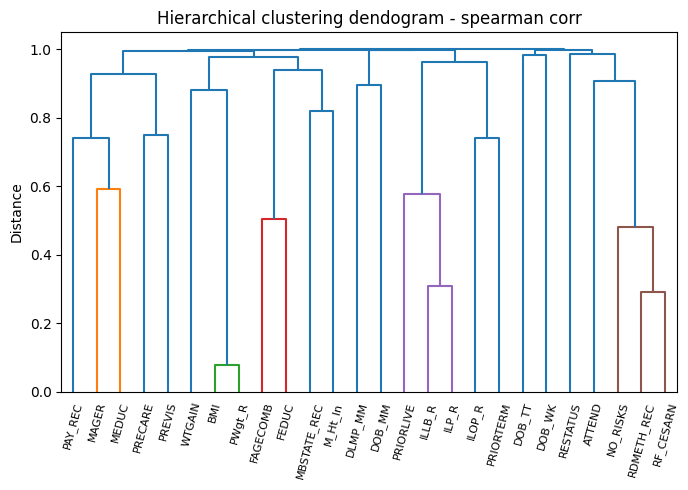

In [17]:
linkage_matrix = hierarchy.linkage(squareform(dissimilarity), method='complete')

import matplotlib.pyplot as plt

# plot the dendogram
fig,ax = plt.subplots(1,1,figsize=(7,5))
dendogram = hierarchy.dendrogram(
    linkage_matrix, ax=ax,
    labels=corr_matrix.columns.tolist(),
)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=75, fontsize=8)
_ = ax.set_ylabel('Distance')
_ = ax.set_title('Hierarchical clustering dendogram - spearman corr')
fig.tight_layout()

In [18]:
train = train.drop(['BMI'], axis=1)
test = test.drop(['BMI'], axis=1)

In [19]:
def add_duration(df:pd.DataFrame):
    df['preg_dur_approx'] = df['DOB_MM'] - df['DLMP_MM']

    # negative durations don't make sense.
    # Credit: https://www.kaggle.com/code/paddykb/lgbm-mapie-birth-weight-oh-my
    df['preg_dur_approx'] = np.where(
        df['preg_dur_approx'] < 0,
        df['preg_dur_approx'] + 12,
        df['preg_dur_approx']
    )

add_duration(train)
add_duration(test)

In [20]:
train.head()

,ATTEND,DLMP_MM,DMAR,DOB_MM,DOB_TT,DOB_WK,FAGECOMB,FEDUC,ILLB_R,ILOP_R,...,PRIORLIVE,PRIORTERM,PWgt_R,RDMETH_REC,RESTATUS,RF_CESARN,SEX,WTGAIN,DBWT,preg_dur_approx
id,,,,,,,,,,,,,,,,,,,,,
0,1,12,,10,1434,5,99,9,888,888,...,0,0,108,1,1,0,F,24,2800,10
1,1,4,1,12,2156,6,39,6,83,999,...,2,1,100,1,1,0,M,18,1900,8
2,1,3,2,12,1241,2,31,4,107,999,...,2,2,135,4,1,2,F,27,2960,9
3,1,7,2,4,1649,2,99,9,888,888,...,0,0,111,3,1,0,M,29,3657,9
4,2,6,1,3,752,2,31,3,55,888,...,2,0,121,4,1,2,F,37,3742,9


In [21]:
test.head()

,ATTEND,DLMP_MM,DMAR,DOB_MM,DOB_TT,DOB_WK,FAGECOMB,FEDUC,ILLB_R,ILOP_R,...,PREVIS,PRIORLIVE,PRIORTERM,PWgt_R,RDMETH_REC,RESTATUS,RF_CESARN,SEX,WTGAIN,preg_dur_approx
id,,,,,,,,,,,,,,,,,,,,,
108082,1,11,,8,1231,4,26,4,888,888,...,18,0,0,125,3,1,0,M,53,9
108083,1,7,1,4,851,5,32,4,25,63,...,15,2,2,103,4,2,2,F,24,9
108084,1,3,2,12,36,6,24,2,20,32,...,16,2,1,203,1,1,0,F,0,9
108085,1,10,2,7,1452,3,32,1,74,888,...,10,1,0,128,1,1,0,F,29,9
108086,1,8,,5,803,4,34,3,98,888,...,11,3,0,130,4,1,1,F,18,9


### Preprocessing

In [22]:
def preparing_data(data, **kwarg):

    X = data.drop('DBWT', axis = 1)
    X.head()
    y = data['DBWT']

    X = pd.get_dummies(X)

    x_train, x_cali, x_test, y_train, y_cali, y_test = train_calibration_test_split(X, y, **kwarg)

    return x_train, x_cali, x_test, y_train, y_cali, y_test

In [23]:
def train_calibration_test_split(X, y, test_pct=0.2, calibration_pct=0.000001, random_state=42):
    """
    Split data into:
    - x_train, y_train for training the model
    - x_cali, y_cali for calibrating the model
    - x_test, y_test for testing the un-seen data
    """
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_pct, random_state=random_state)
    x_train, x_cali, y_train, y_cali = train_test_split(x_train, y_train, test_size=calibration_pct, random_state=random_state)

    return x_train, x_cali, x_test, y_train, y_cali, y_test


In [24]:
x_train, x_cali, x_test, y_train, y_cali, y_test = preparing_data(train)

print(f"x_train's shape: {x_train.shape}")
print(f"x_cali's shape: {x_cali.shape}")
print(f"x_test's shape: {x_test.shape}")
print(f"y_train's shape: {y_train.shape}")
print(f"y_cali's shape: {y_cali.shape}")
print(f"y_test's shape: {y_test.shape}")


x_train's shape: (86464, 33)
x_cali's shape: (1, 33)
x_test's shape: (21617, 33)
y_train's shape: (86464,)
y_cali's shape: (1,)
y_test's shape: (21617,)


### Train lower_model and upper_model using CatBoost

In [25]:
from catboost import CatBoostRegressor

# Each model has to be separate
lower_model = CatBoostRegressor(loss_function='Quantile:alpha=0.045')
# The mid model will use the default loss
upper_model = CatBoostRegressor(loss_function='Quantile:alpha=0.9575')

# fit the model
lower_model.fit(x_train, y_train)
upper_model.fit(x_train, y_train)


0:	learn: 71.2285874	total: 69.8ms	remaining: 1m 9s
1:	learn: 70.0016912	total: 88.1ms	remaining: 44s
2:	learn: 68.8351392	total: 106ms	remaining: 35.3s
3:	learn: 67.7420536	total: 123ms	remaining: 30.6s
4:	learn: 66.7013137	total: 141ms	remaining: 28.1s
5:	learn: 65.7081869	total: 159ms	remaining: 26.3s
6:	learn: 64.8057837	total: 192ms	remaining: 27.3s
7:	learn: 63.9081387	total: 217ms	remaining: 26.9s
8:	learn: 63.0816880	total: 234ms	remaining: 25.8s
9:	learn: 62.3532845	total: 252ms	remaining: 25s
10:	learn: 61.5909541	total: 276ms	remaining: 24.8s
11:	learn: 60.8717384	total: 295ms	remaining: 24.3s
12:	learn: 60.1947241	total: 313ms	remaining: 23.8s
13:	learn: 59.6093065	total: 331ms	remaining: 23.3s
14:	learn: 59.0501009	total: 348ms	remaining: 22.9s
15:	learn: 58.4674065	total: 365ms	remaining: 22.4s
16:	learn: 57.9702861	total: 381ms	remaining: 22s
17:	learn: 57.4564671	total: 397ms	remaining: 21.7s
18:	learn: 57.0009397	total: 414ms	remaining: 21.4s
19:	learn: 56.5676775	tota

### Validate model performance on unseen data


In [26]:
# Add the integer for constant shift the change
Q = -1

In [27]:

y_cali_lower_quantile = lower_model.predict(x_test)
y_cali_upper_quantile = upper_model.predict(x_test)

y_lower_output = y_cali_lower_quantile - Q
y_upper_output = y_cali_upper_quantile + Q


In [28]:
test_set = pd.DataFrame(y_test)
test_set["pi_lower"] = y_lower_output
test_set["pi_upper"] = y_upper_output
test_set.head()

,DBWT,pi_lower,pi_upper
id,,,
33498,3033,2308.442306,3964.606570
7125,3470,2735.045390,4111.314310
8648,2270,2616.988122,3945.780347
74876,3515,2817.309066,4220.853492
12576,3455,1616.771620,3369.154410


In [29]:
score_, coverage = score(test_set.DBWT, y_lower_output, y_upper_output, alpha)

In [30]:
score_

1942.9635097776031

In [31]:
coverage

0.899569783041125

## Generate official submit


In [32]:
test.head()

,ATTEND,DLMP_MM,DMAR,DOB_MM,DOB_TT,DOB_WK,FAGECOMB,FEDUC,ILLB_R,ILOP_R,...,PREVIS,PRIORLIVE,PRIORTERM,PWgt_R,RDMETH_REC,RESTATUS,RF_CESARN,SEX,WTGAIN,preg_dur_approx
id,,,,,,,,,,,,,,,,,,,,,
108082,1,11,,8,1231,4,26,4,888,888,...,18,0,0,125,3,1,0,M,53,9
108083,1,7,1,4,851,5,32,4,25,63,...,15,2,2,103,4,2,2,F,24,9
108084,1,3,2,12,36,6,24,2,20,32,...,16,2,1,203,1,1,0,F,0,9
108085,1,10,2,7,1452,3,32,1,74,888,...,10,1,0,128,1,1,0,F,29,9
108086,1,8,,5,803,4,34,3,98,888,...,11,3,0,130,4,1,1,F,18,9


In [33]:
official_test_data = pd.get_dummies(test)

In [34]:
official_test_data

,ATTEND,DLMP_MM,DOB_MM,DOB_TT,DOB_WK,FAGECOMB,FEDUC,ILLB_R,ILOP_R,ILP_R,...,RF_CESARN,WTGAIN,preg_dur_approx,DMAR_,DMAR_1,DMAR_2,LD_INDL_N,LD_INDL_Y,SEX_F,SEX_M
id,,,,,,,,,,,,,,,,,,,,,
108082,1,11,8,1231,4,26,4,888,888,888,...,0,53,9,1,0,0,1,0,0,1
108083,1,7,4,851,5,32,4,25,63,25,...,2,24,9,0,1,0,1,0,1,0
108084,1,3,12,36,6,24,2,20,32,20,...,0,0,9,0,0,1,0,1,1,0
108085,1,10,7,1452,3,32,1,74,888,74,...,0,29,9,0,0,1,0,1,1,0
108086,1,8,5,803,4,34,3,98,888,98,...,1,18,9,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113766,1,4,1,1239,5,30,6,28,40,28,...,0,35,9,0,1,0,0,1,1,0
113767,1,2,11,2126,3,29,5,25,888,25,...,0,21,9,1,0,0,1,0,0,1
113768,1,11,8,349,2,37,5,102,888,102,...,1,38,9,0,0,1,1,0,0,1


In [35]:
y_cali_lower_quantile = lower_model.predict(official_test_data)
y_cali_upper_quantile = upper_model.predict(official_test_data)

In [36]:
y_lower_output = y_cali_lower_quantile - Q
y_upper_output = y_cali_upper_quantile + Q
print(Q)

-1


In [37]:
stacked_array = np.stack((y_lower_output, y_upper_output))
result = pd.DataFrame(stacked_array.T, columns=["pi_lower", "pi_upper"])

In [38]:
result

,pi_lower,pi_upper
0,2504.963575,4234.894109
1,2502.667104,3698.437154
2,2620.544258,3940.566016
3,2564.344750,3927.611828
4,2460.741072,3811.637850
...,...,...
5684,2728.140016,3987.074452
5685,2887.508821,4196.053486
5686,2784.303805,4368.929589
5687,2684.294087,4025.707917


In [39]:
test_copy = test.copy()

test_copy["pi_lower"]= np.array(result["pi_lower"])
test_copy["pi_upper"]= np.array(result["pi_upper"])

final_output = test_copy[["pi_lower", "pi_upper"]]
final_output.head()

,pi_lower,pi_upper
id,,
108082,2504.963575,4234.894109
108083,2502.667104,3698.437154
108084,2620.544258,3940.566016
108085,2564.344750,3927.611828
108086,2460.741072,3811.637850


In [40]:
test_copy["pi_lower"]

id
108082    2504.963575
108083    2502.667104
108084    2620.544258
108085    2564.344750
108086    2460.741072
             ...     
113766    2728.140016
113767    2887.508821
113768    2784.303805
113769    2684.294087
113770    2768.619293
Name: pi_lower, Length: 5689, dtype: float64

In [41]:
final_output.head()

,pi_lower,pi_upper
id,,
108082,2504.963575,4234.894109
108083,2502.667104,3698.437154
108084,2620.544258,3940.566016
108085,2564.344750,3927.611828
108086,2460.741072,3811.637850


In [42]:
i += 1
print(f"Generate submit_catboost_{i}.csv")
final_output.to_csv(f"submit_catboost_{i}.csv")

Generate submit_catboost_1.csv


### Save the models

In [45]:
_ = joblib.dump(lower_model, 'catboost_lower_model_14.pkl')
_ = joblib.dump(upper_model, 'catboost_upper_model_14.pkl')

### Try to regenerate the results

In [47]:
lower_test = joblib.load('catboost_lower_model_14.pkl')
upper_test = joblib.load('catboost_upper_model_14.pkl')

In [48]:
y_lower_test = lower_test.predict(official_test_data)
y_upper_test = upper_test.predict(official_test_data)

In [49]:
y_lower_test -= Q
y_upper_test += Q

In [67]:
stacked_array = np.stack((y_lower_output, y_upper_output))
test_result = pd.DataFrame(stacked_array.T, columns=["pi_lower", "pi_upper"])
test_result

,pi_lower,pi_upper
0,2504.963575,4234.894109
1,2502.667104,3698.437154
2,2620.544258,3940.566016
3,2564.344750,3927.611828
4,2460.741072,3811.637850
...,...,...
5684,2728.140016,3987.074452
5685,2887.508821,4196.053486
5686,2784.303805,4368.929589
5687,2684.294087,4025.707917


In [68]:
assert test_result.equals(result), "Regenerate result is DIFFERENT!!!. Please recheck"